In [6]:
from scipy.io import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math, time 
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import pipeline
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, Normalizer

# LDA & SVM mnist Classification

In [37]:
# Define Paths

# train_num='1'
# test_num='7'
# num_nanowires='100'
# Time = '30'
test_type='LDA' #LDA
kernel_type='linear' #linear, rbf - kernel options for SVM
# date_of_training='14'
# date_of_testing='14'

# path="C:/Users/aloe8475/Documents/PhD/GitHub/CODE/Analysis/Classification/Kevin Data/"
path="C:/Users/aloe8475/Documents/PhD/GitHub/CODE/Analysis/Classification/Time Serieis/"
#Train with a testing file:
# filename_train = path + 'Net_Sx_20_NoW100_03_25-2019_11_23_38_Zdenka_Square_1SimsOnly_10_Sec_4Electrodes_Vmax_0.5_Testing Simulation_' + train_num + '_' + date_of_training + '-Jun-2019_ForPython.mat'

#Train with normal file:
# filename_train = path + '6000hwdata_Amp1.mat'
filename_train = path + 'DOW_current_Multi1.mat'
filename_data = path + 'IMPORT.csv'
# filename_train_save= test_type+'_Training Simulation_'+ train_num + '_' + Time + '_Sec_' + num_nanowires +'nw_' + date_of_training + '-Jun-2019_KEVIN' 

#Test with training file:
# filename_test = path + 'Net_Sx_20_NoW100_03_25-2019_11_23_38_Zdenka_Square_1SimsOnly_10_Sec_4Electrodes_Vmax_0.5_Training Simulation_' + test_num + '_' + date_of_testing + '-Jun-2019_ForPython.mat'

#Test with normal file
# filename_test= path + 'DOW_result1.3.mat'
# filename_test = path+ '6000hwdata_Result1.mat'

# if test_type == 'SVM':
#     filename_test_save= test_type+'_'+kernel_type+'_kernel'+'_Testing Simulation_' + test_num +'_' + Time + '_Sec_' + num_nanowires + 'nw_' + date_of_testing + '-Jun-2019' 
# else:
# #     filename_test_save= test_type+'_Testing Simulation_' + test_num +'_' + Time + '_Sec_' + num_nanowires + 'nw_' + date_of_testing + '-Jun-2019_KEVIN' 

# filename = 'Alon_Code/Data/Testing/Extracted_test_2.mat'

In [85]:
Start_Time=700;


# Load the Training data

data1=loadmat(filename_train)

data2= pd.read_csv(filename_data,header=None,squeeze=True)

TargetPattern = (data2[Start_Time+1:])>0
IOutput = data1['recurrent'].T[[1,3],:]#.todense()
IOutput = IOutput[:,Start_Time*10:-10] #from the start time to the 1 time point before the end
IOutput=IOutput[:,4::10]  # Downsampling
# IOutput=IOutput/np.std(IOutput,1,keepdims=True)

IDrain1_Train=IOutput[0,:]
IDrain2_Train=IOutput[1,:]
# IDrain3_Train=IOutput[2,:]
# IDrain4_Train=IOutput[3,:]
# TargetPattern = data2['result']

# nanidx=np.isnan(CPattern).sum(axis=1)==0
# CPattern=CPattern[nanidx]
# TargetPattern=TargetPattern[nanidx]

In [86]:
IDrain1_Train=np.atleast_2d(IDrain1_Train).T
IDrain2_Train=np.atleast_2d(IDrain2_Train).T
# IDrain3_Train=np.atleast_2d(IDrain3_Train).T
# IDrain4_Train=np.atleast_2d(IDrain4_Train).T

In [87]:
TargetPattern=(TargetPattern.values)#.astype(int)

In [88]:
TargetPattern.shape

(557,)

C:\Users\aloe8475\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\aloe8475\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


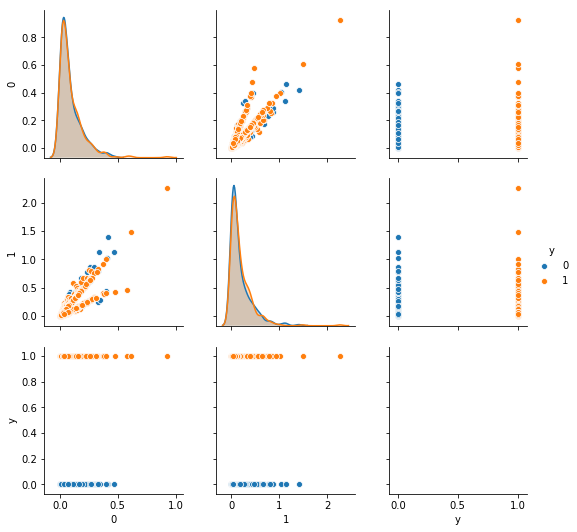

In [89]:
df = pd.DataFrame(IOutput.T*10000)
df['y'] = TargetPattern.astype(int)
# df.plot.scatter(0, 1, c = 'y', cmap = 'viridis')
sns.pairplot(data=df,hue='y')
# df.head()

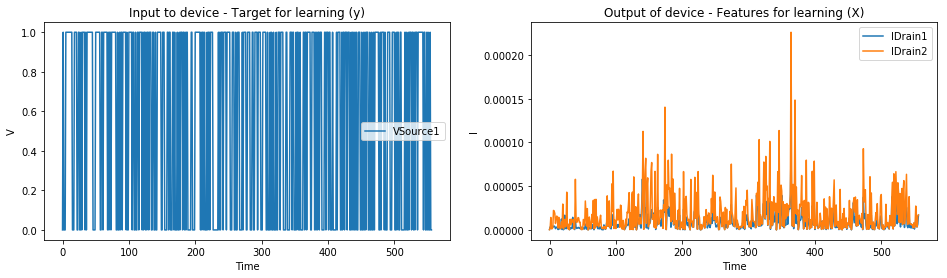

In [90]:
# Explore
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].plot(TargetPattern, label = 'VSource1')
axes[0].set_title("Input to device - Target for learning (y)"); axes[0].set_xlabel('Time'); axes[0].set_ylabel('V')
axes[0].legend()
axes[1].plot(IDrain1_Train, label = 'IDrain1'); axes[1].plot(IDrain2_Train, label = 'IDrain2')#;  axes[1].plot(IDrain3_Train, label = 'IDrain3'); axes[1].plot(IDrain4_Train, label = 'IDrain4')
axes[1].set_title("Output of device - Features for learning (X)"); axes[1].set_xlabel('Time'); axes[1].set_ylabel('I')
axes[1].legend()

In [91]:

# SPLIT INTO TRAIN AND TEST:

# X_train, X_test, y_train, y_test = train_test_split(CPattern, TargetPattern, test_size = 200, random_state = 10)

X_train = np.hstack([IDrain1_Train[:-200], IDrain2_Train[:-200]])#, IDrain3_Train[:-100], IDrain4_Train[:-100]])
y_train = TargetPattern[:-200]

# X_train=IOutput[:,:-100]
# y_train=TargetPattern[:-100]
X_test=np.hstack([IDrain1_Train[-200:], IDrain2_Train[-200:]])#, IDrain3_Train[-100:], IDrain4_Train[-100:]])
y_test= TargetPattern[-200:]

# IPattern_Train=IPattern[list(range(int(len(IPattern)/2))),:]
# IPattern_Test=IPattern[int(len(IPattern)/2):len(IPattern),:]

# TargetPattern_Train=TargetPattern[list(range(int(len(IPattern)/2))),:]
# TargetPattern_Test=TargetPattern[int(len(IPattern)/2):len(IPattern),:]
# for i in range(len(IPattern)):
#     IPattern[i]=IPattern[i,:]

# IDrain2_Train=IDrain[:,1].todense()
# VSource1_Train=VSource[:,0]
# VSource2_Train=VSource[:,1]

In [92]:
IDrain2_Train.shape

(557, 1)

In [93]:
X_train.shape

(357, 2)

In [94]:
X_test.shape

(200, 2)

In [95]:
y_train.shape

(357,)

In [96]:
y_test.shape

(200,)

In [97]:
# # Split the data


X=X_train
y=y_train
X_Test=X_test
y_Test=y_test
# X = np.vstack([X_train])
# y = np.vstack([y_train])
# y = np.argmax(y,axis=1)


# X_Test=np.vstack([X_test])
# y_Test=np.vstack([y_test])
# y_Test = np.argmax(y_Test,axis=1)
# y2 = VSource2_Train[start_time:].ravel()
# y2 = (y2 == np.nanmax(y2)) * 2
# if multi_class:
#     y = y + y2

# X[:,1] = X[:,1] / X[:,0]
# scalar = StandardScaler()
# scalar = Normalizer(norm = 'l2')
# X = scalar.fit_transform(X)
# # X = (X - X.mean(axis = 0)) / X.std(axis = 0)
# # X = (X - X.mean(axis = 0)) / X.std(axis = 0)
# # X = (X - X.mean(axis = 1)) / X.std(axis = 1)
# X = np.asarray(X) * 1

# sns.kdeplot(X[:,0][y], X[:,1][y])
# sns.kdeplot(X[:,0][~y], X[:,1][~y])
# fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# axes[0].scatter(X[:,0], X[:,1], c = y, marker = 'x', cmap = 'Set1', alpha = 0.1);

# axes[1].plot(X[:,0], label = 'IDrain1'); axes[1].plot(X[:,1], label = 'IDrain2')
# axes[1].set_title("Output of device - Features for learning (X)"); axes[1].set_xlabel('Time'); axes[1].set_ylabel('A')
# axes[1].legend()

In [99]:
# # Training
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0, random_state = 0)



# if test_type=='SVM':

# grid.fit(X, y)
# print (grid.score(X_test, y_Test))
# print ('best parameters from train data: ', grid.best_params_)

# y_pred = grid.predict(X_Test)

# clf = SVC(C=1,kernel='linear',probability=False).fit(X, y) #change kernel here
# elif test_type=='LDA':
clf = LinearDiscriminantAnalysis().fit(X, y)
# clf = RandomForestClassifier().fit(X, y)

predictedValues = clf.predict(X_Test)
# print(X.shape)
print('Train accuracy:', clf.score(X, y))
print('Test accuracy:', clf.score(X_Test, y_Test))


Train accuracy: 0.5770308123249299
Test accuracy: 0.535


In [ ]:
predictedValues==y_Test